## Table des matières

- [Création de l'échantillon 'data'](#chapitre_1)
- [Dendrogramme](#chapitre_2)
- [Coupage du dendrogramme en 5 clusters](#chapitre_3)
- [Caractérisation des clusters selon les variables](#chapitre_4)
- [Visualisation dans le premier plan factoriel obtenu par ACP](#chapitre_5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings('ignore')

population = pd.read_csv("population_2016_2017.csv")
dispAlim = pd.read_csv("disp_alim_totale_2017.csv")
dispAlimAnimaux = pd.read_csv("disp_alim_animaux_2017.csv")
#PIBparHab = pd.read_csv("PIB_par_Hab.csv")

L'étude se base sur les chiffres de la FAO de l'année 2017.

<a id="chapitre_1"></a>
## <span style="color: #030aa4">Création de l'échantillon 'data'</span>

In [2]:
# Création de dataPop pour la population de chaque pays en 2016 et 2017 :

dataPop = population.loc[ : ,('Code zone','Zone','Année','Valeur')]\
                    .pivot_table(index = ['Code zone','Zone'], columns = 'Année', values='Valeur', aggfunc = sum)\
                    .reset_index()

# Vu dans projet 3 :
# La Chine apparaît deux fois :
# - Chine, continentale (Code zone = 41), donnée officielle
# - Chine (Code zone = 351), agrégat incluant des données non officielles

# Suppression de l'élément "Chine" avec le code zone : 

dataPop = dataPop[dataPop["Code zone"]!=351]

# Création colonne "Différence de population entre 2016 et 2017" :

dataPop['Différence de population entre 2016 et 2017 en %'] = ((dataPop[2017]-dataPop[2016])/dataPop[2016])*100

# Création de dataAlim pour la disponibilité alimentaire totale :

dataAlim = dispAlim.pivot_table(index =['Zone','Code zone'],
                            columns='Élément', values='Valeur', aggfunc = sum)\
                   .loc[ : ,('Disponibilité alimentaire (Kcal/personne/jour)',
                             'Disponibilité de protéines en quantité (g/personne/jour)')]\
                   .reset_index()\
                   .rename(columns={'Disponibilité alimentaire (Kcal/personne/jour)':'Disponibilité alimentaire totale (Kcal/personne)',
                                    'Disponibilité de protéines en quantité (g/personne/jour)':'Disponibilité totale de protéines en quantité (g/personne)'})
dataAlim['Disponibilité alimentaire totale (Kcal/personne)'] *= 365
dataAlim['Disponibilité totale de protéines en quantité (g/personne)'] *= 365

# Suppression des valeurs incohérentes :

dataAlim = dataAlim.drop(dataAlim[dataAlim['Disponibilité alimentaire totale (Kcal/personne)']<0].index)\
                   .drop(dataAlim[dataAlim['Disponibilité totale de protéines en quantité (g/personne)']<0].index)\
                   .drop_duplicates()

# Création de dataAnim pour la disponibilité alimentaire animale :

dataAnim = dispAlimAnimaux.pivot_table(index =['Zone','Code zone'],
                            columns='Élément', values='Valeur', aggfunc = sum)\
                          .loc[ : ,('Disponibilité de protéines en quantité (g/personne/jour)')]\
                          .reset_index()\
                          .rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)':"Disponibilité d'origine animale de protéines en quantité (g/personne)"})
dataAnim["Disponibilité d'origine animale de protéines en quantité (g/personne)"] *= 365

# Suppression des valeurs incohérentes :

dataAnim = dataAnim.drop(dataAnim[dataAnim["Disponibilité d'origine animale de protéines en quantité (g/personne)"]<0].index)\
                   .drop_duplicates()

# Jointure de dataPop, dataAlim et dataAnim : 

data = pd.merge(dataPop, dataAlim)
data = pd.merge(data, dataAnim)

data["Proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %"] = (data["Disponibilité d'origine animale de protéines en quantité (g/personne)"]/data['Disponibilité totale de protéines en quantité (g/personne)'])*100

data = data.drop(columns=['Code zone',2016,2017,"Disponibilité d'origine animale de protéines en quantité (g/personne)"])\
           .set_index('Zone')

data

,Différence de population entre 2016 et 2017 en %,Disponibilité alimentaire totale (Kcal/personne),Disponibilité totale de protéines en quantité (g/personne),Proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %
Zone,,,,
Arménie,0.294604,1123470.0,35540.05,45.773852
Afghanistan,2.580559,730000.0,19742.85,19.504529
Albanie,-0.078644,1241000.0,43635.75,55.491426
Algérie,2.066020,1222385.0,33912.15,27.671941
Angola,3.377933,828550.0,19750.15,30.456478
...,...,...,...,...
Belgique,0.575371,1375320.0,37065.75,56.986706
Luxembourg,2.183821,1217275.0,38711.90,63.539506
Serbie,-0.274792,1023825.0,30112.50,48.509091


Les pays à cibler doivent avoir :
- une démographie en croissance
- une disponibilité alimentaire totale faible
- une disponibilité totale de protéines faible
- une proportion de protéines faible

<a id="chapitre_2"></a>
## <span style="color: #030aa4">Dendrogramme</span>

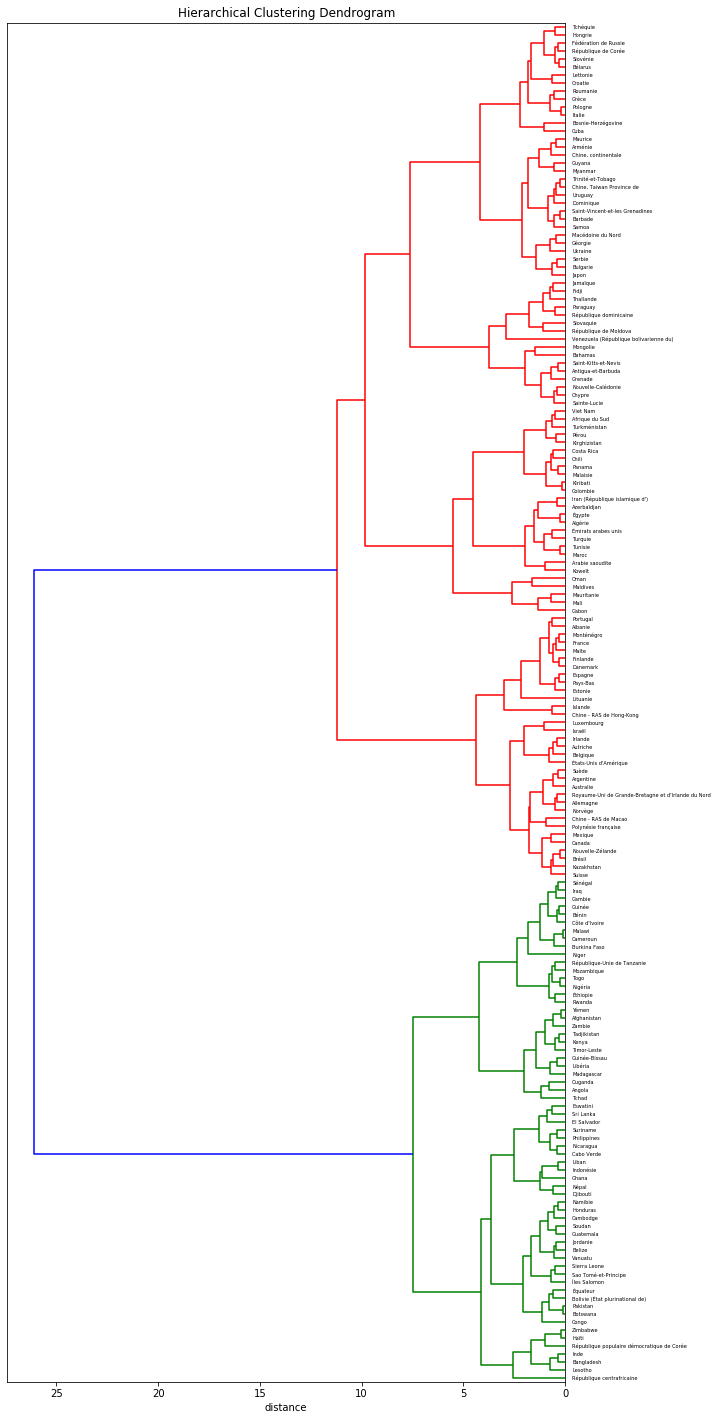

In [3]:
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
from scipy.cluster.hierarchy import linkage, fcluster


# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

<a id="chapitre_3"></a>
## <span style="color: #030aa4">Coupage du dendrogramme en 5 clusters</span>

In [4]:
clusters = fcluster(Z, 5, criterion='maxclust')

dataClusters = pd.DataFrame({"cluster": clusters, "Zone": names})

dataClusters

,cluster,Zone
0,5,Arménie
1,1,Afghanistan
2,2,Albanie
3,3,Algérie
4,1,Angola
...,...,...
165,2,Belgique
166,2,Luxembourg
167,5,Serbie
168,2,Monténégro


<a id="chapitre_4"></a>
## <span style="color: #030aa4">Nombre de pays par clusters</span>

In [5]:
dataClusters["Nombre d'états"]=1

dataClusters.groupby('cluster')["Nombre d'états"].sum()

cluster
1    63
2    33
3    26
4    16
5    32
Name: Nombre d'états, dtype: int64

<a id="chapitre_5"></a>
## <span style="color: #030aa4">Caractérisation des clusters selon les variables</span>

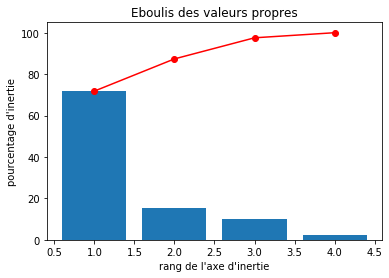

In [11]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

    
# choix du nombre de composantes à calculer
n_comp = 4

# sélection des colonnes à prendre en compte dans l'ACP
data_pca = data[['Différence de population entre 2016 et 2017 en %',
                 'Disponibilité alimentaire totale (Kcal/personne)',
                 'Disponibilité totale de protéines en quantité (g/personne)',
                 "Proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %"]]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = data.index
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

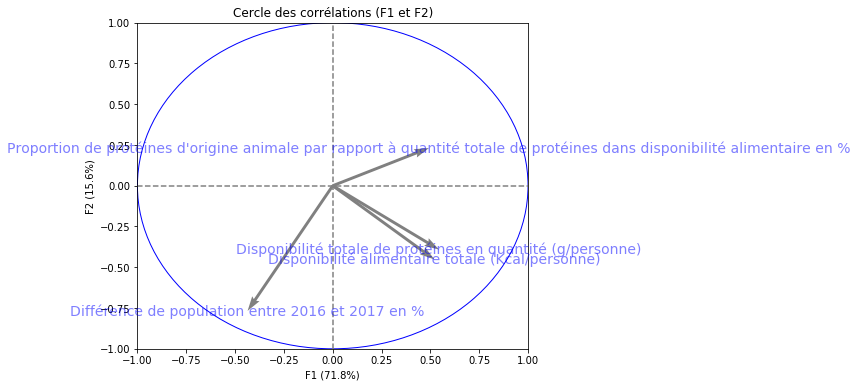

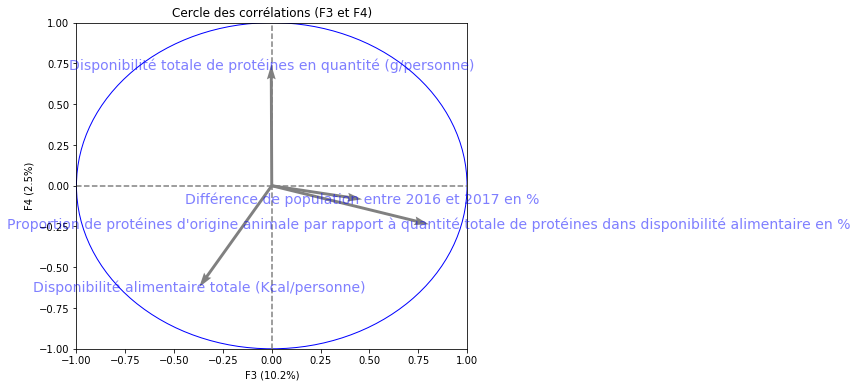

In [12]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

Description des variables synthétiques :
    - F1 augmente si :
        - Différence de population entre 2016 et 2017 diminue
        - Disponibilité alimentaire totale augmente
        - Disponibilité totale de protéines en quantité augmente
        - Proportion de protéine d'origine animale augmente
    - F2 augmente si :
        - Différence de population entre 2016 et 2017 diminue
        - Disponibilité alimentaire totale diminue
        - Disponibilité totale de protéines en quantité diminue
        - Proportion de protéine d'origine animale augmente
    - F3 augmente si :
        - Différence de population entre 2016 et 2017 augmente
        - Disponibilité alimentaire totale diminue       
        - Proportion de protéine d'origine animale augmente
    - F4 augmente si :       
        - Disponibilité alimentaire totale diminue
        - Disponibilité totale de protéines en quantité augmente
        
**Nous cherchons donc le cluster avec des valeurs de F1 les plus basses.**

<a id="chapitre_6"></a>
## <span style="color: #030aa4">Données centrées réduites</span>

In [13]:
pd.DataFrame(X_scaled, columns = data.columns, index= data.index)

,Différence de population entre 2016 et 2017 en %,Disponibilité alimentaire totale (Kcal/personne),Disponibilité totale de protéines en quantité (g/personne),Proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %
Zone,,,,
Arménie,-0.855507,0.483957,0.799657,0.187544
Afghanistan,1.158549,-1.884710,-1.337967,-1.459245
Albanie,-1.184360,1.191481,1.895139,0.796725
Algérie,0.705211,1.079420,0.579375,-0.947241
Angola,1.861081,-1.291445,-1.336979,-0.772682
...,...,...,...,...
Belgique,-0.608136,2.000080,1.006109,0.890462
Luxembourg,0.809000,1.048658,1.228861,1.301249
Serbie,-1.357178,-0.115900,0.065219,0.359012


<a id="chapitre_7"></a>
## <span style="color: #030aa4">Calcul des composantes principales</span>

In [17]:
X_scaled = preprocessing.StandardScaler().fit_transform(data.values)
pca = decomposition.PCA(n_components=4)
X_projected = pca.fit_transform(X_scaled)
dataCP= pd.DataFrame(X_projected, index=data.index, columns = ["F"+str(i+1) for i in range(4)])

dataParCluster = pd.merge(dataClusters,dataCP, on='Zone')\
                   .drop(columns="Nombre d'états")

dataParCluster

,cluster,Zone,F1,F2,F3,F4
0,5,Arménie,1.152456,0.168039,-0.426846,0.319595
1,1,Afghanistan,-2.933405,0.149293,0.065254,0.427211
2,2,Albanie,2.560490,-0.187444,-0.354441,0.576011
3,3,Algérie,0.103236,-1.475020,-0.838611,-0.076156
4,1,Angola,-2.591914,-0.499632,0.722589,-0.161921
...,...,...,...,...,...,...
165,2,Belgique,2.292729,-0.625445,-0.310331,-0.656685
166,2,Luxembourg,1.503255,-1.275047,1.028920,-0.115394
167,5,Serbie,0.743594,1.151373,-0.296192,0.148950
168,2,Monténégro,2.594772,-0.158641,-0.110213,0.151591


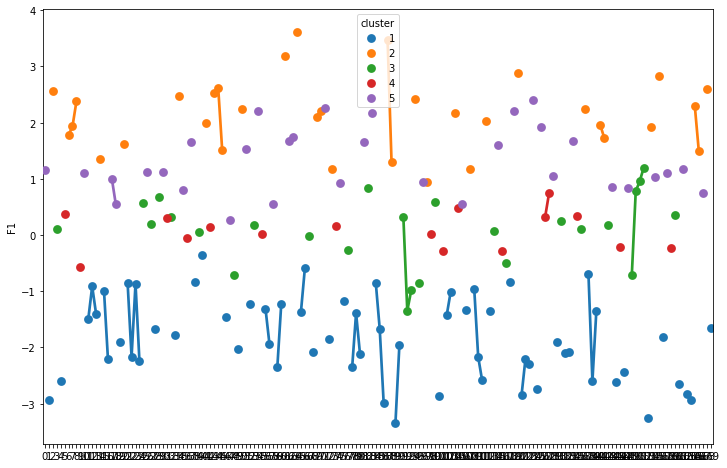

In [19]:
plt.figure(figsize=(12,8))

sns.pointplot(x= dataParCluster.index, y='F1',data=dataParCluster, hue='cluster')

Le cluster 1 a les valeurs de F1 les plus basses. Elles sont toutes négatives.
Ce qui signifie que ses individus ont :
- L'augmentation de population entre 2016 et 2017 la plus élevée
- La disponibilité alimentaire totale la plus faible
- La disponibilité en quantité de protéine la plus faible
- La proportion de protéine d'origine animale la plus faible

**Les individus du cluster 1 sont les pays à cibler pour notre étude de marché.** 

<a id="chapitre_8"></a>
## <span style="color: #030aa4">Liste des pays à cibler</span>

In [25]:
PaysCibles = dataClusters[dataClusters.cluster==1]\
                        .drop(columns=["Nombre d'états","cluster"])

PaysCibles.head(10)

,Zone
1,Afghanistan
4,Angola
11,Bangladesh
12,Bolivie (État plurinational de)
13,Botswana
15,Belize
16,Îles Salomon
19,Cameroun
21,Cabo Verde
22,République centrafricaine


<a id="chapitre_9"></a>
## <span style="color: #030aa4">Projection des individus</span>

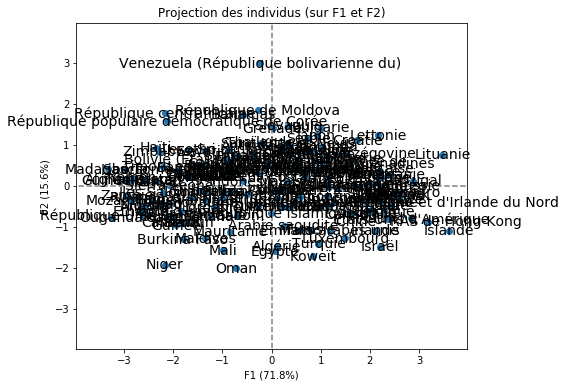

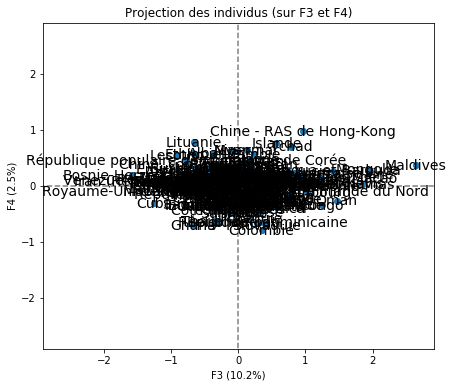

In [16]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], labels = np.array(names))

plt.show()

<a id="chapitre_10"></a>
## <span style="color: #030aa4">Visualisation dans le premier plan factoriel obtenu par ACP</span>

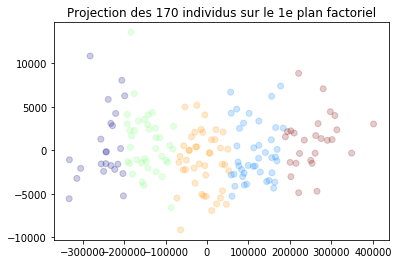

In [20]:
from sklearn.cluster import KMeans

# Nombre de clusters souhaités
n_clust = 5

# préparation des données pour le clustering
X = data.values

# Réduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

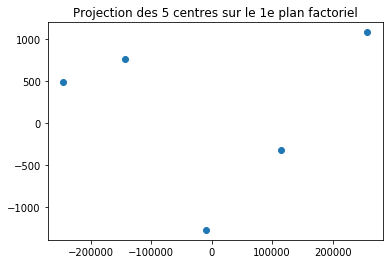

In [18]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

<a id="chapitre_6"></a>
## <span style="color: #030aa4">Test d'adéquation</span>

Les variables sont continues, nous alons utiliser le test de Shapiro-Wilk qui teste l'hypothèse nulle selon laquelle un échantillon est normalement distribué.

In [19]:
import scipy.stats 

def test_adequation(variable):
    variable = data.columns
    for i in variable :
        pvalue = scipy.stats.shapiro(data[i])[0]
        if pvalue > 0.05 :
            return
            print("La p-value est égale à", round(pvalue,2),".")
            print("Elle est est supérieure au niveau de test 5%.")
            print("On ne peut pas rejeter l'hypothèse nulle.")
        else:
            return 
            print("La p-value est égale à", round(pvalue,2),".")
            print("Elle est est inférieure au niveau de test 5%.")
            print("On peut rejeter l'hypothèse nulle.")
            print("L'échantillon n'est pas normalement distribué.")
 

test_adequation(variable)

In [21]:
pvalue = scipy.stats.shapiro(data['Différence de population entre 2016 et 2017 en %'])[0]

if pvalue > 0.05 :
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne peut pas rejeter l'hypothèse nulle.")
else:
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse nulle.")
    print("L'échantillon n'est pas normalement distribué.")

La p-value est égale à 0.99 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.


In [22]:
pvalue = scipy.stats.shapiro(data['Disponibilité alimentaire totale (Kcal/personne)'])[0]

if pvalue > 0.05 :
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne peut pas rejeter l'hypothèse nulle.")
else:
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse nulle.")
    print("L'échantillon n'est pas normalement distribué.")

La p-value est égale à 0.98 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.


In [23]:
pvalue = scipy.stats.shapiro(data['Disponibilité totale de protéines en quantité (g/personne)'])[0]

if pvalue > 0.05 :
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne peut pas rejeter l'hypothèse nulle.")
else:
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse nulle.")
    print("L'échantillon n'est pas normalement distribué.")

La p-value est égale à 0.98 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.


In [25]:
pvalue = scipy.stats.shapiro(data["Proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %"])[0]

if pvalue > 0.05 :
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne peut pas rejeter l'hypothèse nulle.")
else:
    print("La p-value est égale à", round(pvalue,2),".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse nulle.")
    print("L'échantillon n'est pas normalement distribué.")

La p-value est égale à 0.96 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
